# An Examination of Vaccination and Covid-19  in India

# Executive Summary
### Problem: 
Covid-19 is causing great harm to India.
### Solution: 
Analysis of Covid-19 data across states can identify best/worst responding states, which can be used to improve vaccination, treatment, and prevention protocols. <br> <br>
What one state is doing right can be transferred to other states. <br> <br>
What one state is doing wrong can be prevented in other states.
### Key Findings:
The state in India has tremendous impact on the number of people cured of Covid-19, the number of people killed by Covid-19, and the number of adverse reactions to vaccines (AEFI). <br> <br>
Of the three states examined: <br>
- Delhi is poor at infection spread and AEFI
- Tamil Nadu is poor at infection spread and good at preventing AEFI
- Madhy Pradesh is good at limiting infection spread but poor at AEFI

# Data Source

Covid-19 in India <br>
Dataset on Novel Corona Virus Disease 2019 in India <br>
Author: Sudalairaj Kumar <br>
Data acquired from Kaggle: <br>
https://www.kaggle.com/sudalairajkumar/covid19-in-india?select=covid_19_india.csv <br>
<br>
Files acquired:
- covid_19_india.csv
- covid_vaccine_statewise.csv
- StatewiseTestingDetails.csv

# Data Dictionary
- state: the state in which observations were recorded.
- date: the date at which observations were reported (not necessarily when observations occurred).
- cured: the reported number of patients cured of Covid-19.
- deaths: the reported number of patients killed by Covid-19.
- total_doses: the total doses of all Covid-19 vaccines administered.
- covaxin: the doses of covaxin administered.
- covishield: the doses of covishield administered.
- sputnik: the doses of sputnik administered.
- AEFI: the reported number of adverse reactions to Covid-19 vaccines.
- young_adults_vaccinated: 18-44 yr olds vaccinated.
- midaged_vaccinated: 45 yr olds vaccinated.
- elderly_vaccinated: 60+ yr olds vaccinated.
- males_vaccinated: number of males vaccinated.
- females_vaccinated: number of females vaccinated.

# Planning
### Features to be used from covid_19_india.csv:
- State
- Date
- Cured
- Deaths
<br>
### Features to be used from covid_vaccine_statewise.csv: <br>
- State
- Date
- Total Doses
- AEFI
- Vaccine type
<br> <br>
### Overall Process
- Drop 'Sno' because it can't be combined with other tables, we are going for state-wide view instead of individual patient view.
- Clean 'State' columns in each file so that they are equivalent.
- Perform other data preparation
- Create a dataframe for each state from the source files, then join the same state dataframes on state. Next, concatenate the different state dataframes into one.
- First look at data as time-series, then as multi-factorial
<br> <br>
### Follow the standard data science pipeline:
<br>
Acquire -> Prepare -> Explore -> Model -> Delivery


# Acquire

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from scipy.stats import pearsonr, spearmanr, ttest_ind

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

# Sets precision of 2 and suppresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Seperates thousands, millions, etc with commas
pd.options.display.float_format = '{:,}'.format

import helper_file

### Create dataset from local csv's.

In [2]:
df, vaccine_df = helper_file.aquire_data()

### Examine the Covid-19 survival dataset.

In [3]:
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [5]:
state_from_df = pd.Series(np.unique(df['State/UnionTerritory']))
state_from_df

0                  Andaman and Nicobar Islands
1                               Andhra Pradesh
2                            Arunachal Pradesh
3                                        Assam
4                                        Bihar
5                                    Bihar****
6             Cases being reassigned to states
7                                   Chandigarh
8                                 Chhattisgarh
9                       Dadra and Nagar Haveli
10    Dadra and Nagar Haveli and Daman and Diu
11                                 Daman & Diu
12                                       Delhi
13                                         Goa
14                                     Gujarat
15                                     Haryana
16                            Himachal Pradesh
17                           Himanchal Pradesh
18                           Jammu and Kashmir
19                                   Jharkhand
20                                  Karanataka
21           

In [6]:
state_from_df.shape

(46,)

### Examine the Covid-19 vaccination dataset.

In [7]:
vaccine_df.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),...,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
0,16/01/2021,India,"48,276.0","3,455.0","2,957.0","48,276.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"23,757.0","24,517.0",2.0,"48,276.0"
1,17/01/2021,India,"58,604.0","8,532.0","4,954.0","58,604.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"27,348.0","31,252.0",4.0,"58,604.0"
2,18/01/2021,India,"99,449.0","13,611.0","6,583.0","99,449.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"41,361.0","58,083.0",5.0,"99,449.0"
3,19/01/2021,India,"195,525.0","17,855.0","7,951.0","195,525.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"81,901.0","113,613.0",11.0,"195,525.0"
4,20/01/2021,India,"251,280.0","25,472.0","10,504.0","251,280.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"98,111.0","153,145.0",24.0,"251,280.0"


In [8]:
vaccine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Updated On                           7845 non-null   object 
 1   State                                7845 non-null   object 
 2   Total Doses Administered             7621 non-null   float64
 3   Sessions                             7621 non-null   float64
 4    Sites                               7621 non-null   float64
 5   First Dose Administered              7621 non-null   float64
 6   Second Dose Administered             7621 non-null   float64
 7   Male (Doses Administered)            7461 non-null   float64
 8   Female (Doses Administered)          7461 non-null   float64
 9   Transgender (Doses Administered)     7461 non-null   float64
 10   Covaxin (Doses Administered)        7621 non-null   float64
 11  CoviShield (Doses Administered

In [9]:
state_from_vaccine = pd.Series(np.unique(vaccine_df.State))
state_from_vaccine

0                  Andaman and Nicobar Islands
1                               Andhra Pradesh
2                            Arunachal Pradesh
3                                        Assam
4                                        Bihar
5                                   Chandigarh
6                                 Chhattisgarh
7     Dadra and Nagar Haveli and Daman and Diu
8                                        Delhi
9                                          Goa
10                                     Gujarat
11                                     Haryana
12                            Himachal Pradesh
13                                       India
14                           Jammu and Kashmir
15                                   Jharkhand
16                                   Karnataka
17                                      Kerala
18                                      Ladakh
19                                 Lakshadweep
20                              Madhya Pradesh
21           

In [10]:
# The number of states between the files is different
state_from_vaccine.shape

(37,)

### Takeaways from Acquire: <br>
- Survival dataset has few nulls, the other dataset has some columns with no or few nulls and some columns with many nulls.
- Survival dataset has a unique serial number for each case, the other file does not.
- The number of states in the two datasets are not equal.
- Nothing like a patient_id tying patient outcome to vaccination status.
- Some column names are not coding-safe

# Prepare

Clean the data before further analysis.

In [11]:
df, vaccine_df = helper_file.prepare_data(df, vaccine_df)

Columns for 'state' in the datasets have been make equivalent to each other.

In [12]:
state_from_df = pd.Series(np.unique(df['state']))
state_from_vaccine = pd.Series(np.unique(vaccine_df.state))
state_from_df == state_from_vaccine

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
dtype: bool

Combine survival and vaccination datasets into a single dataframe.

In [13]:
sum_df = helper_file.combine_data(df, vaccine_df)

### Three states were chosen for examination.
### The states were assigned numbers so that they could be a variable in statistical tests.
Delhi: 1 <br>
Tamil Nadu: 2 <br>
Madhya Pradesh: 3 <br> <br>

Examine the new combined dataframe.

In [14]:
sum_df.head()

,state,cured,deaths,month,total_doses,covaxin,covishield,sputnik,AEFI,young_adults_vaccinated,midaged_vaccinated,elderly_vaccinated,males_vaccinated,females_vaccinated
0,1,0,0,3,"69,462.0","4,863.0","64,599.0",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,3,"443,842.0","79,096.0","314,923.0",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,3,"1,493,167.0","373,679.0","1,119,488.0",0.0,687.0,"284,791.0","417,320.0","509,140.0",0.0,0.0
3,1,0,0,3,"3,415,728.0","1,054,775.0","2,360,953.0",0.0,810.0,"450,157.0","1,319,948.0","906,172.0",0.0,0.0
4,1,0,0,3,"5,559,386.0","1,687,996.0","3,871,390.0",0.0,947.0,"1,596,795.0","1,667,590.0","1,027,440.0",0.0,0.0


In [15]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28179 entries, 0 to 28178
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    28179 non-null  int64  
 1   cured                    28179 non-null  int64  
 2   deaths                   28179 non-null  int64  
 3   month                    28179 non-null  int64  
 4   total_doses              28179 non-null  float64
 5   covaxin                  28179 non-null  float64
 6   covishield               28179 non-null  float64
 7   sputnik                  28179 non-null  float64
 8   AEFI                     28179 non-null  float64
 9   young_adults_vaccinated  28179 non-null  float64
 10  midaged_vaccinated       28179 non-null  float64
 11  elderly_vaccinated       28179 non-null  float64
 12  males_vaccinated         28179 non-null  float64
 13  females_vaccinated       28179 non-null  float64
dtypes: float64(10), int64(

In [16]:
sum_df.describe().T

,count,mean,std,min,25%,50%,75%,max
state,"28,179.0",1.9809787430355938,0.8148970666696392,1.0,1.0,2.0,3.0,3.0
cured,"28,179.0","557,229.4399375422","638,619.4633498784",0.0,"9,804.0","277,484.0","828,441.0","2,524,400.0"
deaths,"28,179.0","8,485.53050143724","9,264.836433269156",0.0,435.0,"4,235.0","12,425.0","34,367.0"
month,"28,179.0",4.679122750984776,1.9332004820278503,1.0,3.0,5.0,6.0,8.0
total_doses,"28,179.0","8,005,072.918875759","8,000,295.274909517",0.0,"1,294,057.0","6,094,030.0","10,381,633.0","34,901,221.0"
covaxin,"28,179.0","1,249,405.879591185","1,087,747.1728877272",0.0,"217,158.0","1,023,820.0","2,103,455.0","3,793,500.0"
covishield,"28,179.0","6,745,927.587565208","7,023,150.103453053",0.0,"1,080,010.0","4,590,051.0","8,685,808.0","31,218,147.0"
sputnik,"28,179.0","3,782.926292629263","9,184.519012811194",0.0,0.0,0.0,525.0,"44,856.0"
AEFI,"28,179.0",421.8265374924589,377.7614784751564,0.0,85.0,316.0,809.0,"1,068.0"
young_adults_vaccinated,"28,179.0","740,988.1384719117","1,303,233.3118194095",0.0,0.0,"277,349.0","846,393.0","8,342,482.0"


Univariate exploration

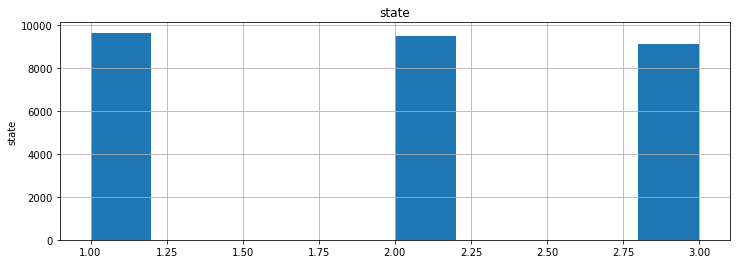

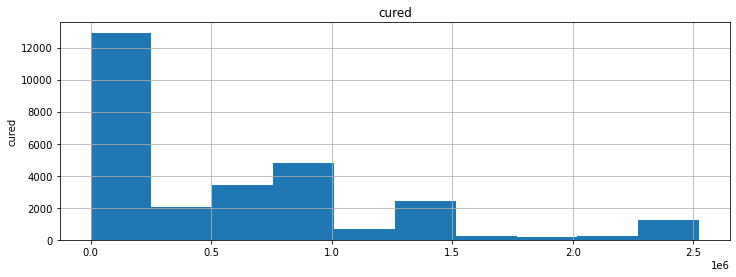

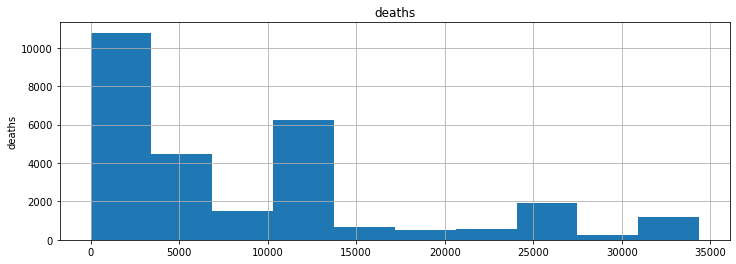

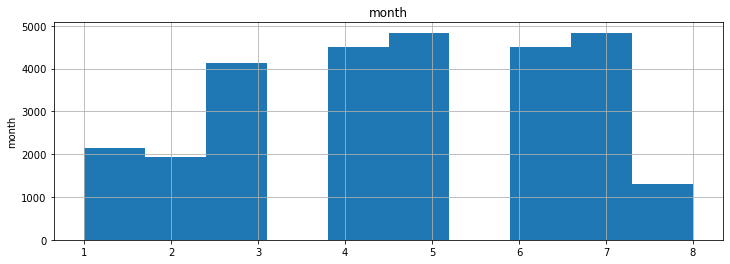

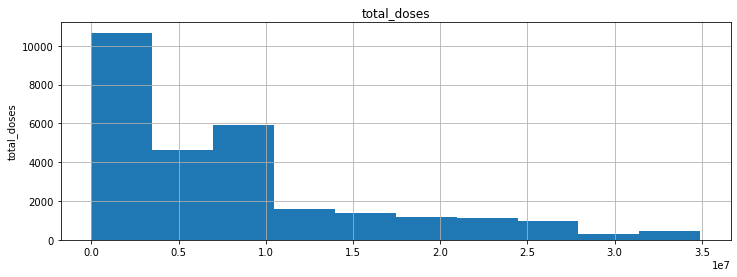

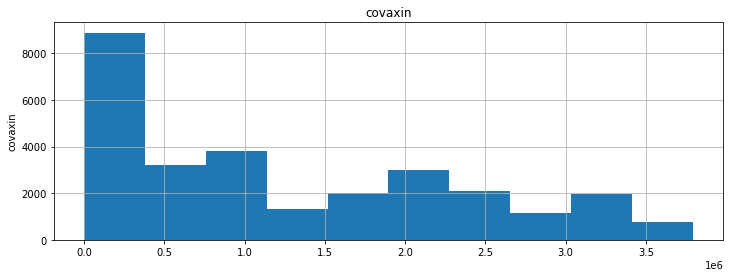

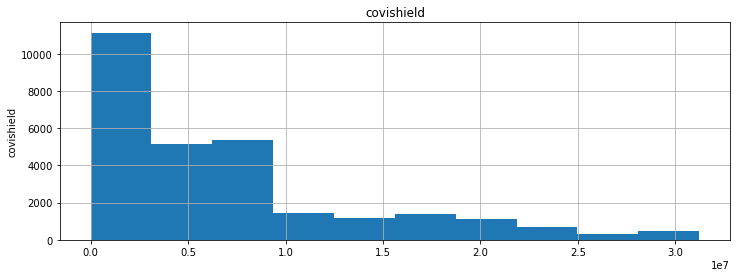

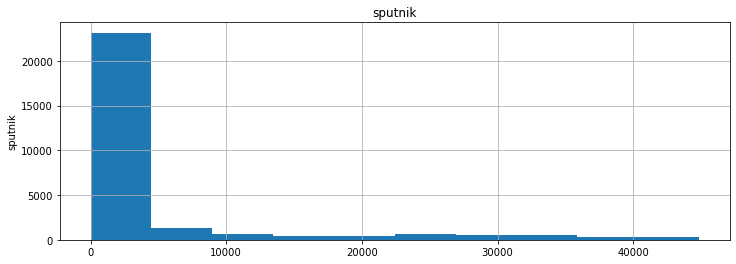

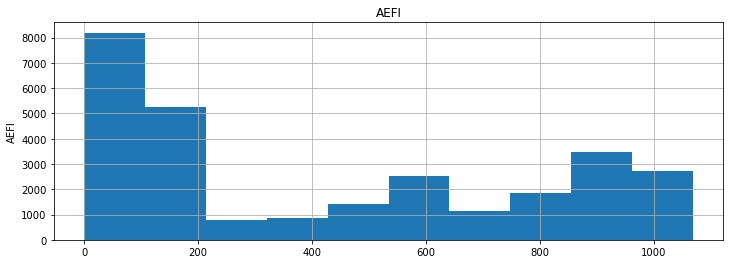

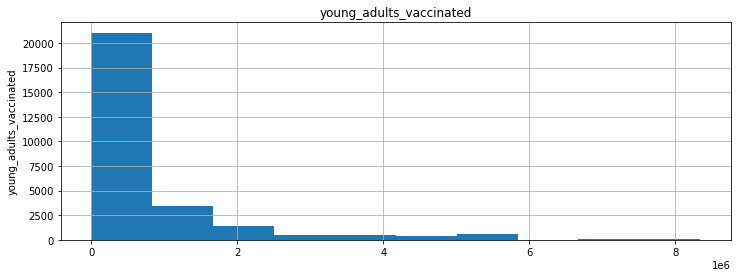

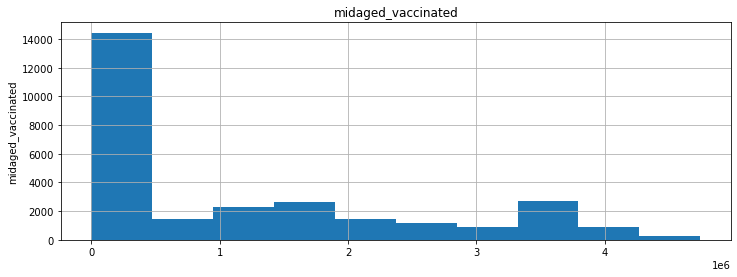

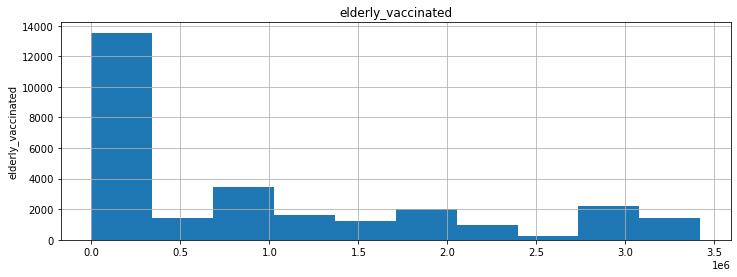

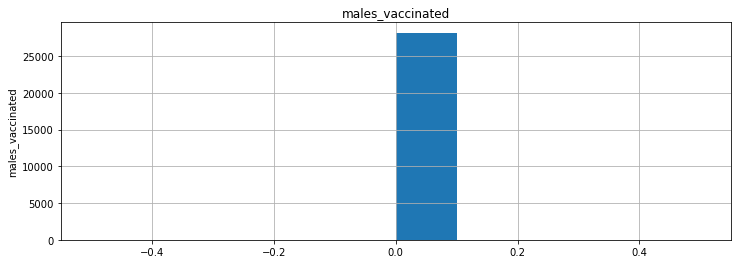

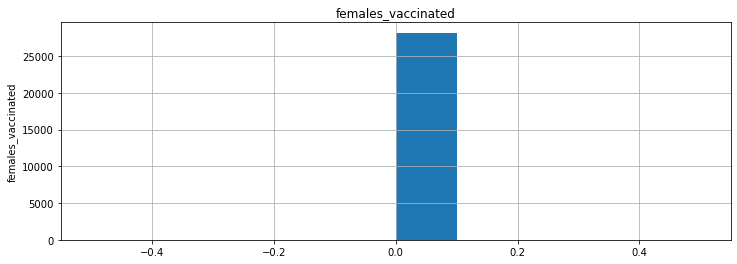

In [17]:
helper_file.univariate_exploration(sum_df)

### Takeaways for Prepare:
- Organized the two dataframes by month and state, and then combined the dataframes
- Huge short-lived spikes when looking at daily periods, observations may have been saved for reporting dates
- Both cured and deaths start out high and then decrease over time
- AEFI starts high, decreases largely, then slightly increases towards the end
- Vaccination in general starts high, and then decreases

# Explore

- This plot has multiple overlapping curves.
- There are probably different groups with different survival rates.

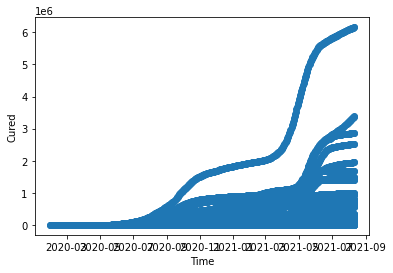

In [18]:
helper_file.time_v_cured_daily(df)

- Much of the vaccination data has large short-lived spikes and isolated points.
- This may be because clinics are holding their data until a periodic reporting date.
- These spikes can be removed by resampling by month.

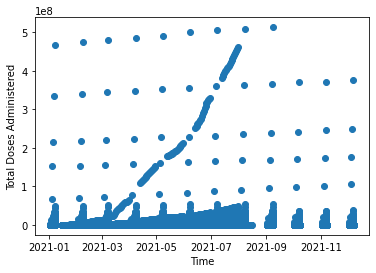

In [19]:
helper_file.vaccine_v_doses_daily(vaccine_df)

Data is resampled by month and grouped by state, which addresses issues with visualization and makes data manipulation easier.

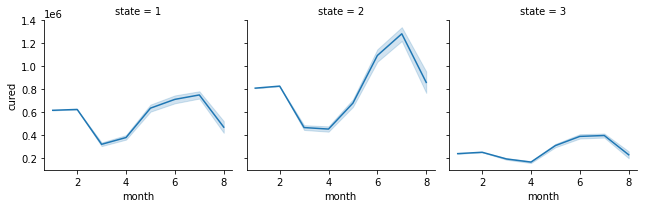

In [20]:
helper_file.month_state_v_cured(sum_df)

- The plots for cured and deaths appear almost identical.
- This is because more infections means more of both cured and deaths.
- Since cured/deaths are similar between states, the effictiveness of treating infected may also be similar between states.
- The spread of infection probably differs greatly by state.
- The curves for Delhi and Tamil Nadu have similar shapes.
- The curve for Madhya appears suppressed.

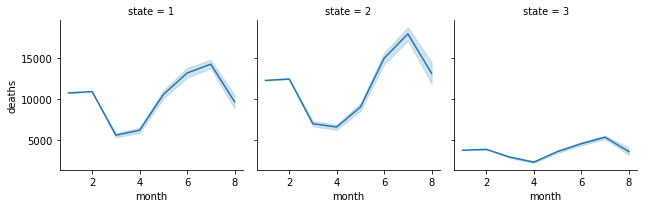

In [21]:
helper_file.state_month_v_deaths(sum_df)

'total_doses' administered increases to a peak, then drops sharply.

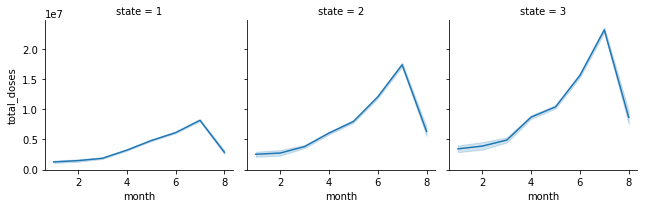

In [22]:
helper_file.state_month_v_doses(sum_df)

AEFI was surpressed in Tamil Nadu

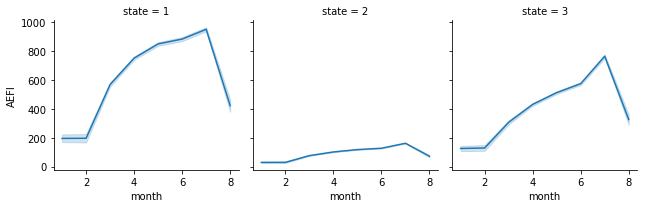

In [23]:
helper_file.state_month_v_AEFI(sum_df)

-Vaccine types over time increase to a peak and then decrease. <br>
-In terms of doses administered: <br>
covishield >> covaxin > sputnik

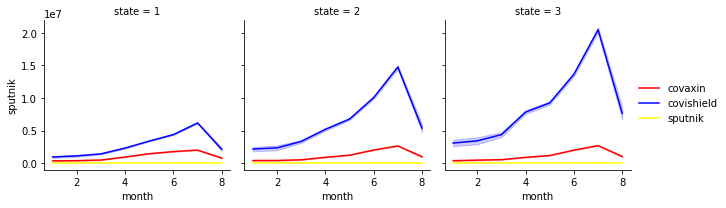

In [24]:
helper_file.proportion_vaccines(sum_df)

- There appears to be an early effort to vaccinate the middle-aged and elderly.
- Vaccination of young adults began in earnest in the middle of the time frame and peaked after the other ages peaked.
- All age groups had a steep drop in vaccinations at around month 6.

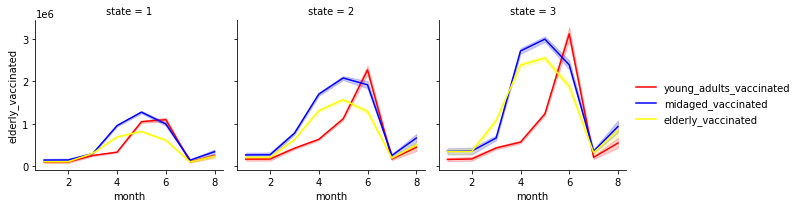

In [25]:
helper_file.month_v_vaccination_age(sum_df)

- Vaccination by gender is two overlapping straight lines.
- The lines may be straight because of how the vaccines were procured.
- The lines may be overlapping because of a effort towards gender equity.

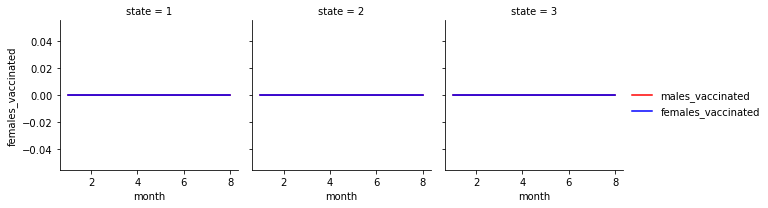

In [26]:
helper_file.month_v_gender(sum_df)

### A cycical pattern can't be seen in the time-frame of this dataset.
### Time-series forecasting methods should not be used with this dataset

- Split the data into train, validate, test for multi-factorial testing.
- Stratify the split by time.

In [27]:
train, validate, test = helper_file.data_split(sum_df)
train.shape, validate.shape, test.shape

((15780, 14), (6763, 14), (5636, 14))

Examine the effects of 'state' on other features.

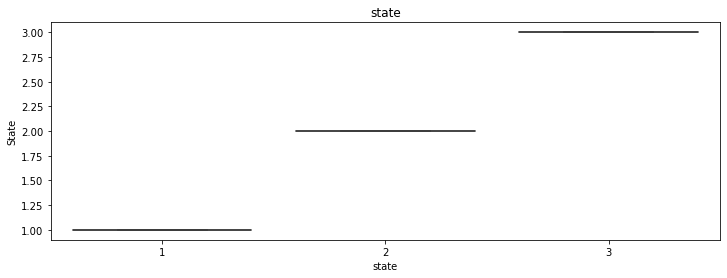

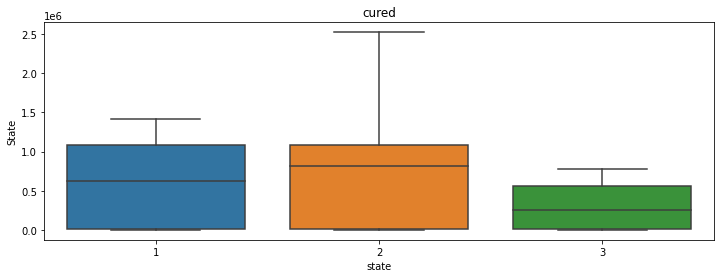

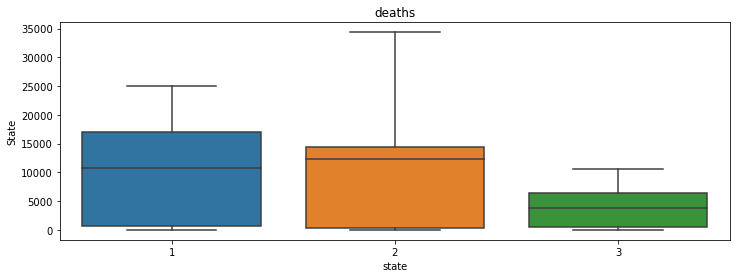

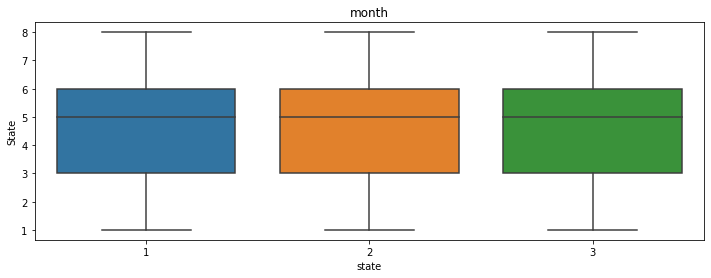

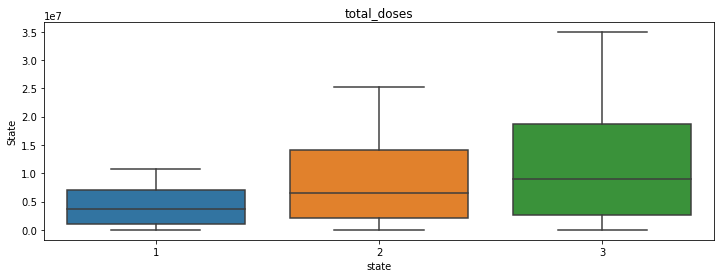

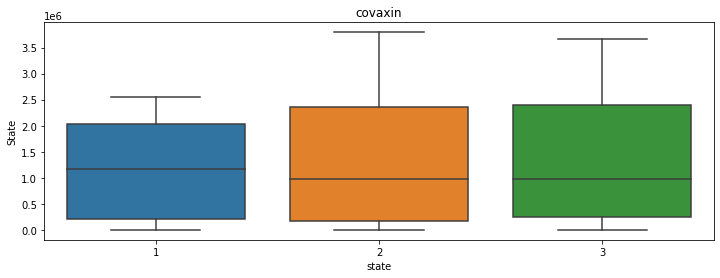

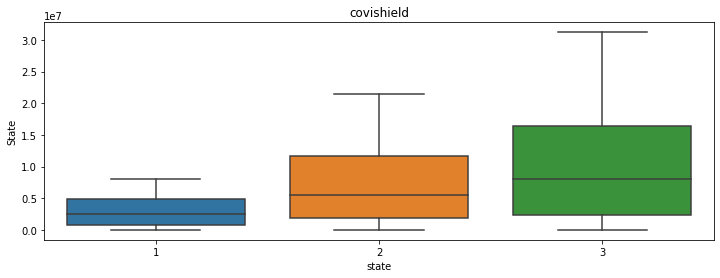

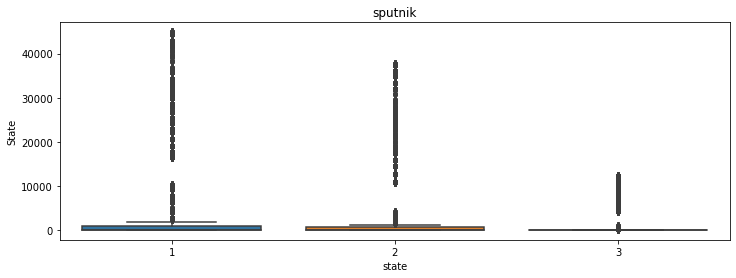

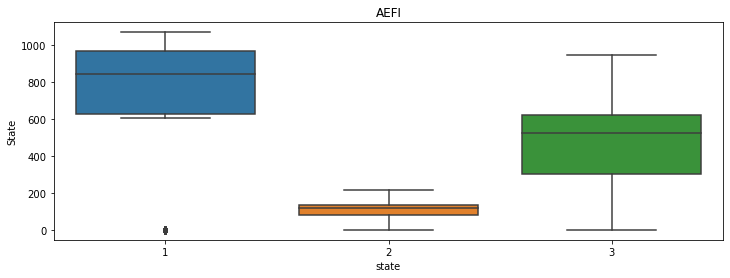

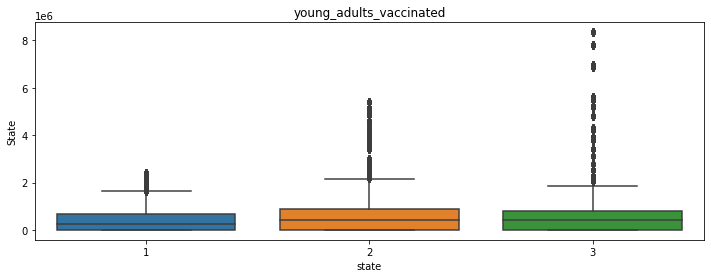

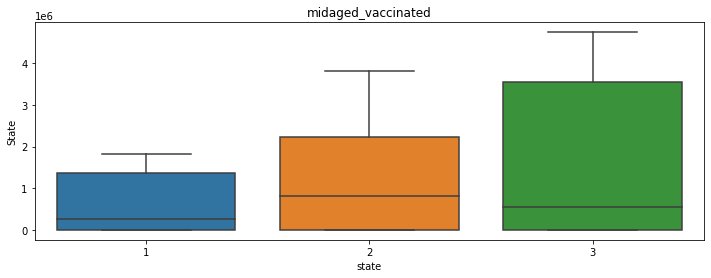

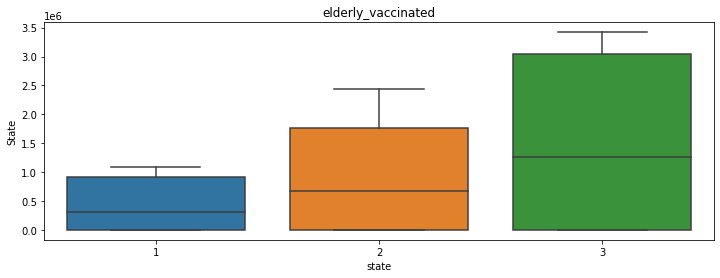

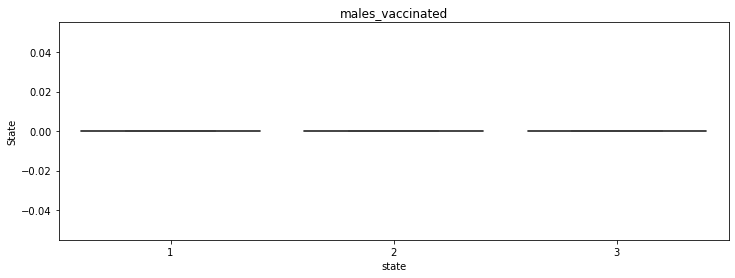

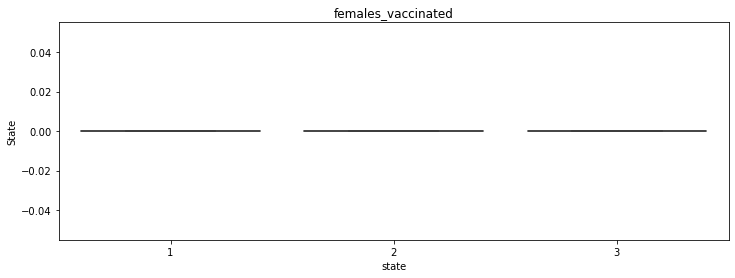

In [28]:
helper_file.state_v_col(train)

- Delhi is poor at infection spread and AEFI.
- Tamil Nadu is poor at infection spread and good at preventing AEFI.
- Madhy Pradesh is good at limiting infection spread but poor at AEFI. <br> <br>
- Deaths and cured seems to dependent on the spread on the disease.
- It appears that state had little impact on peoples survival once already infected.
<br> <br>
- It appears that there was gender equity in giving out the vaccines.
- It appears the the elderly and middle-aged where prioritized over the young for vaccination in the early stages of the epidemic

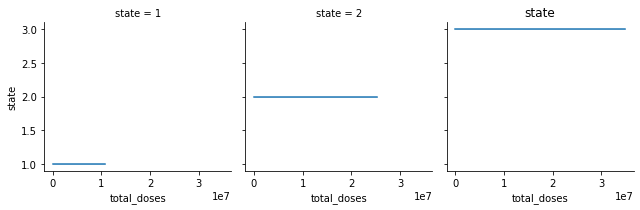

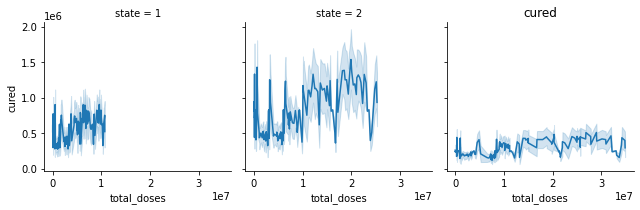

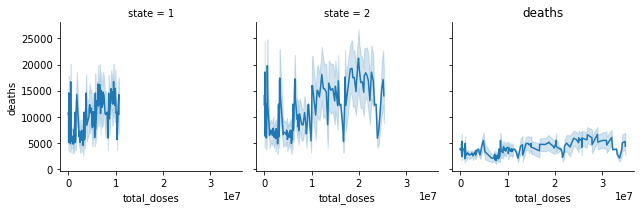

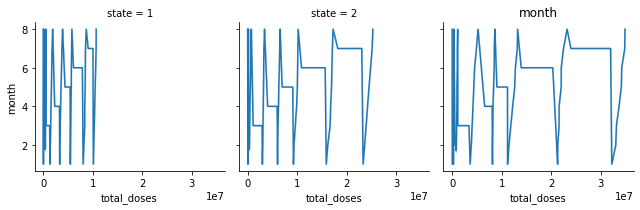

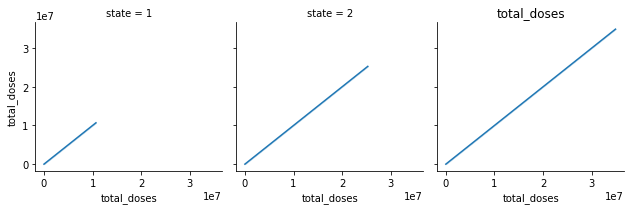

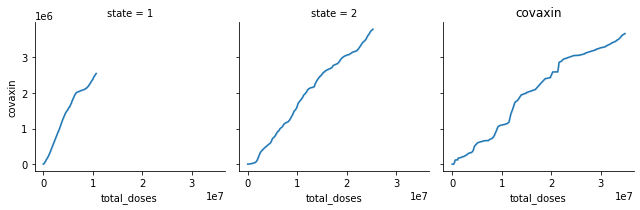

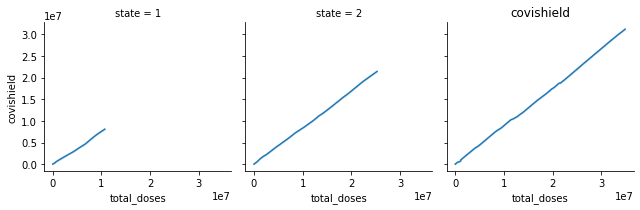

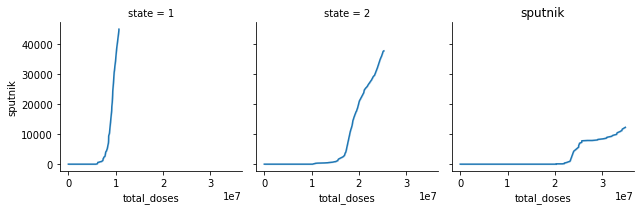

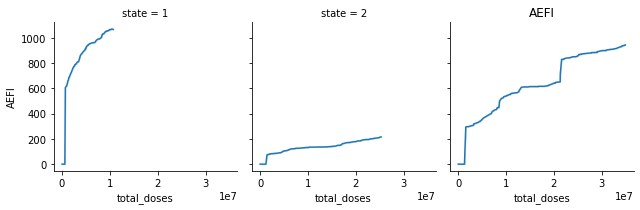

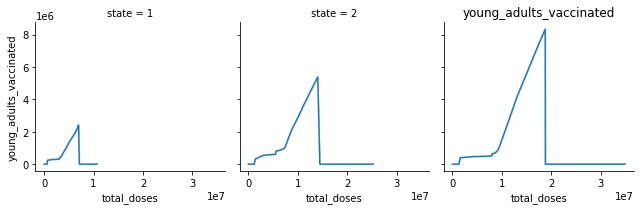

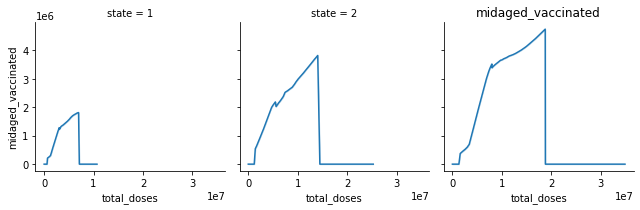

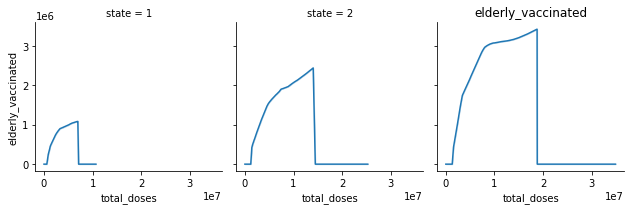

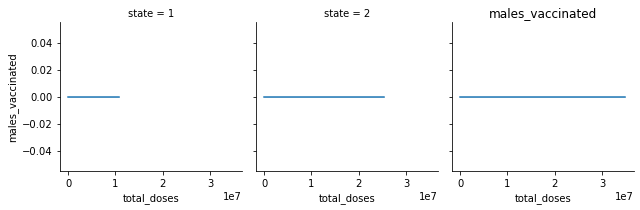

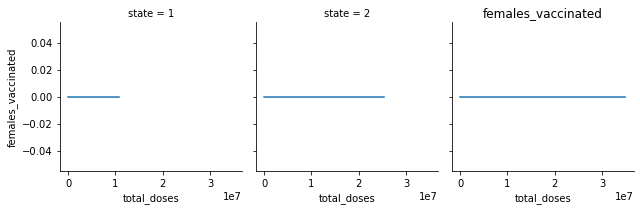

In [29]:
helper_file.doses_v_col(train)

- In terms of doses administered: <br>
covishield >> covaxin > sputnik
<br>
- The proportions of vaccine types appear to be similar across states

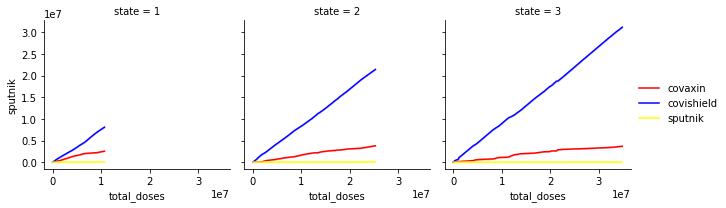

In [30]:
helper_file.doses_v_vaccine_type(train)

- The shape of the curves appears similar across states, because administration of different vaccine types was proportional.
- The stretching of the curves is due to the different amounts of doses administered in different states.
- Vaccine type does not appear to have much effect on AEFI.

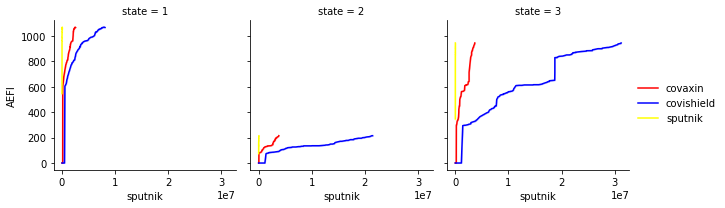

In [31]:
helper_file.vaccine_type_v_AEFI(train)

- Surprisingly, peak AEFI occurs at max vaccination of young adults.

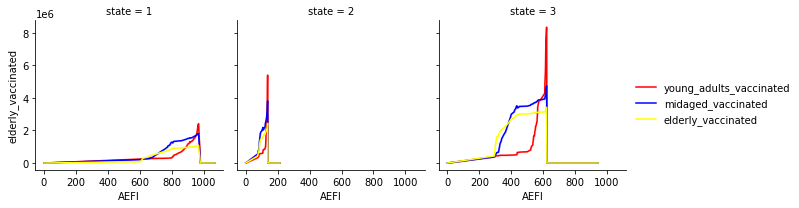

In [32]:
helper_file.age_v_AEFI(train)

The plots for deaths differ greatly by state, but are mostly overlapping by age

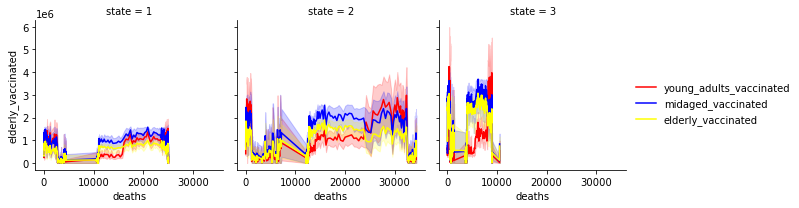

In [33]:
helper_file.deaths_v_age(train)

- 'cured' has the best correlation with 'deaths'
- 'covaxin' has the highest correlation value with AEFI, even higher than 'total_doses'

In [34]:
# Look for correlation between variables
train.corr()

,state,cured,deaths,month,total_doses,covaxin,covishield,sputnik,AEFI,young_adults_vaccinated,midaged_vaccinated,elderly_vaccinated,males_vaccinated,females_vaccinated
state,1.0,-0.17136020609193617,-0.2727995147146556,0.010723988251529329,0.36380966898920936,0.05394570345969756,0.4059684882645216,-0.18556550801301164,-0.2684079074845498,0.15336662644873383,0.2998710842422463,0.3815683253949822,NaN,NaN
cured,-0.17136020609193617,1.0,0.9845086569512865,0.16897272238388622,0.07857073607006605,0.15806215960841172,0.06489722517908847,0.1541643591702811,-0.07126106299930106,0.01747975490407448,-0.07717368773563343,-0.11610142989113854,NaN,NaN
deaths,-0.2727995147146556,0.9845086569512865,1.0,0.17017724617444277,0.030267976630224087,0.14640607993256735,0.011642704284529426,0.18898376651356405,-0.013484343100420315,-0.01754074287951363,-0.12740947008936565,-0.17027163022175995,NaN,NaN
month,0.010723988251529329,0.16897272238388622,0.17017724617444277,1.0,0.48653897470606333,0.5681914899953795,0.46567107481587655,0.3412770464458292,0.34115956425636856,0.17174952494603227,0.08865412395880558,0.048494698286792044,NaN,NaN
total_doses,0.36380966898920936,0.07857073607006605,0.030267976630224087,0.48653897470606333,1.0,0.9112409619654248,0.9979309084145661,0.4486003011012625,0.35574175194961943,0.1357211884659145,0.03641718455872222,0.01407131450334141,NaN,NaN
covaxin,0.05394570345969756,0.15806215960841172,0.14640607993256735,0.5681914899953795,0.9112409619654248,1.0,0.8829296650524578,0.5917621235676155,0.5325214559061496,0.159741367852602,-0.017292832896171135,-0.07595129132923947,NaN,NaN
covishield,0.4059684882645216,0.06489722517908847,0.011642704284529426,0.46567107481587655,0.9979309084145661,0.8829296650524578,1.0,0.418161143113761,0.3230501309892537,0.1305821433424633,0.045315803217169104,0.028985486477859753,NaN,NaN
sputnik,-0.18556550801301164,0.1541643591702811,0.18898376651356405,0.3412770464458292,0.4486003011012625,0.5917621235676155,0.418161143113761,1.0,0.3178795203076104,-0.22767189502486726,-0.33580794021984756,-0.3394779036766106,NaN,NaN
AEFI,-0.2684079074845498,-0.07126106299930106,-0.013484343100420315,0.34115956425636856,0.35574175194961943,0.5325214559061496,0.3230501309892537,0.3178795203076104,1.0,0.09137865143636079,0.04794556516048369,0.023650119389210796,NaN,NaN
young_adults_vaccinated,0.15336662644873383,0.01747975490407448,-0.01754074287951363,0.17174952494603227,0.1357211884659145,0.159741367852602,0.1305821433424633,-0.22767189502486726,0.09137865143636079,1.0,0.7625840890411864,0.6872934507199109,NaN,NaN


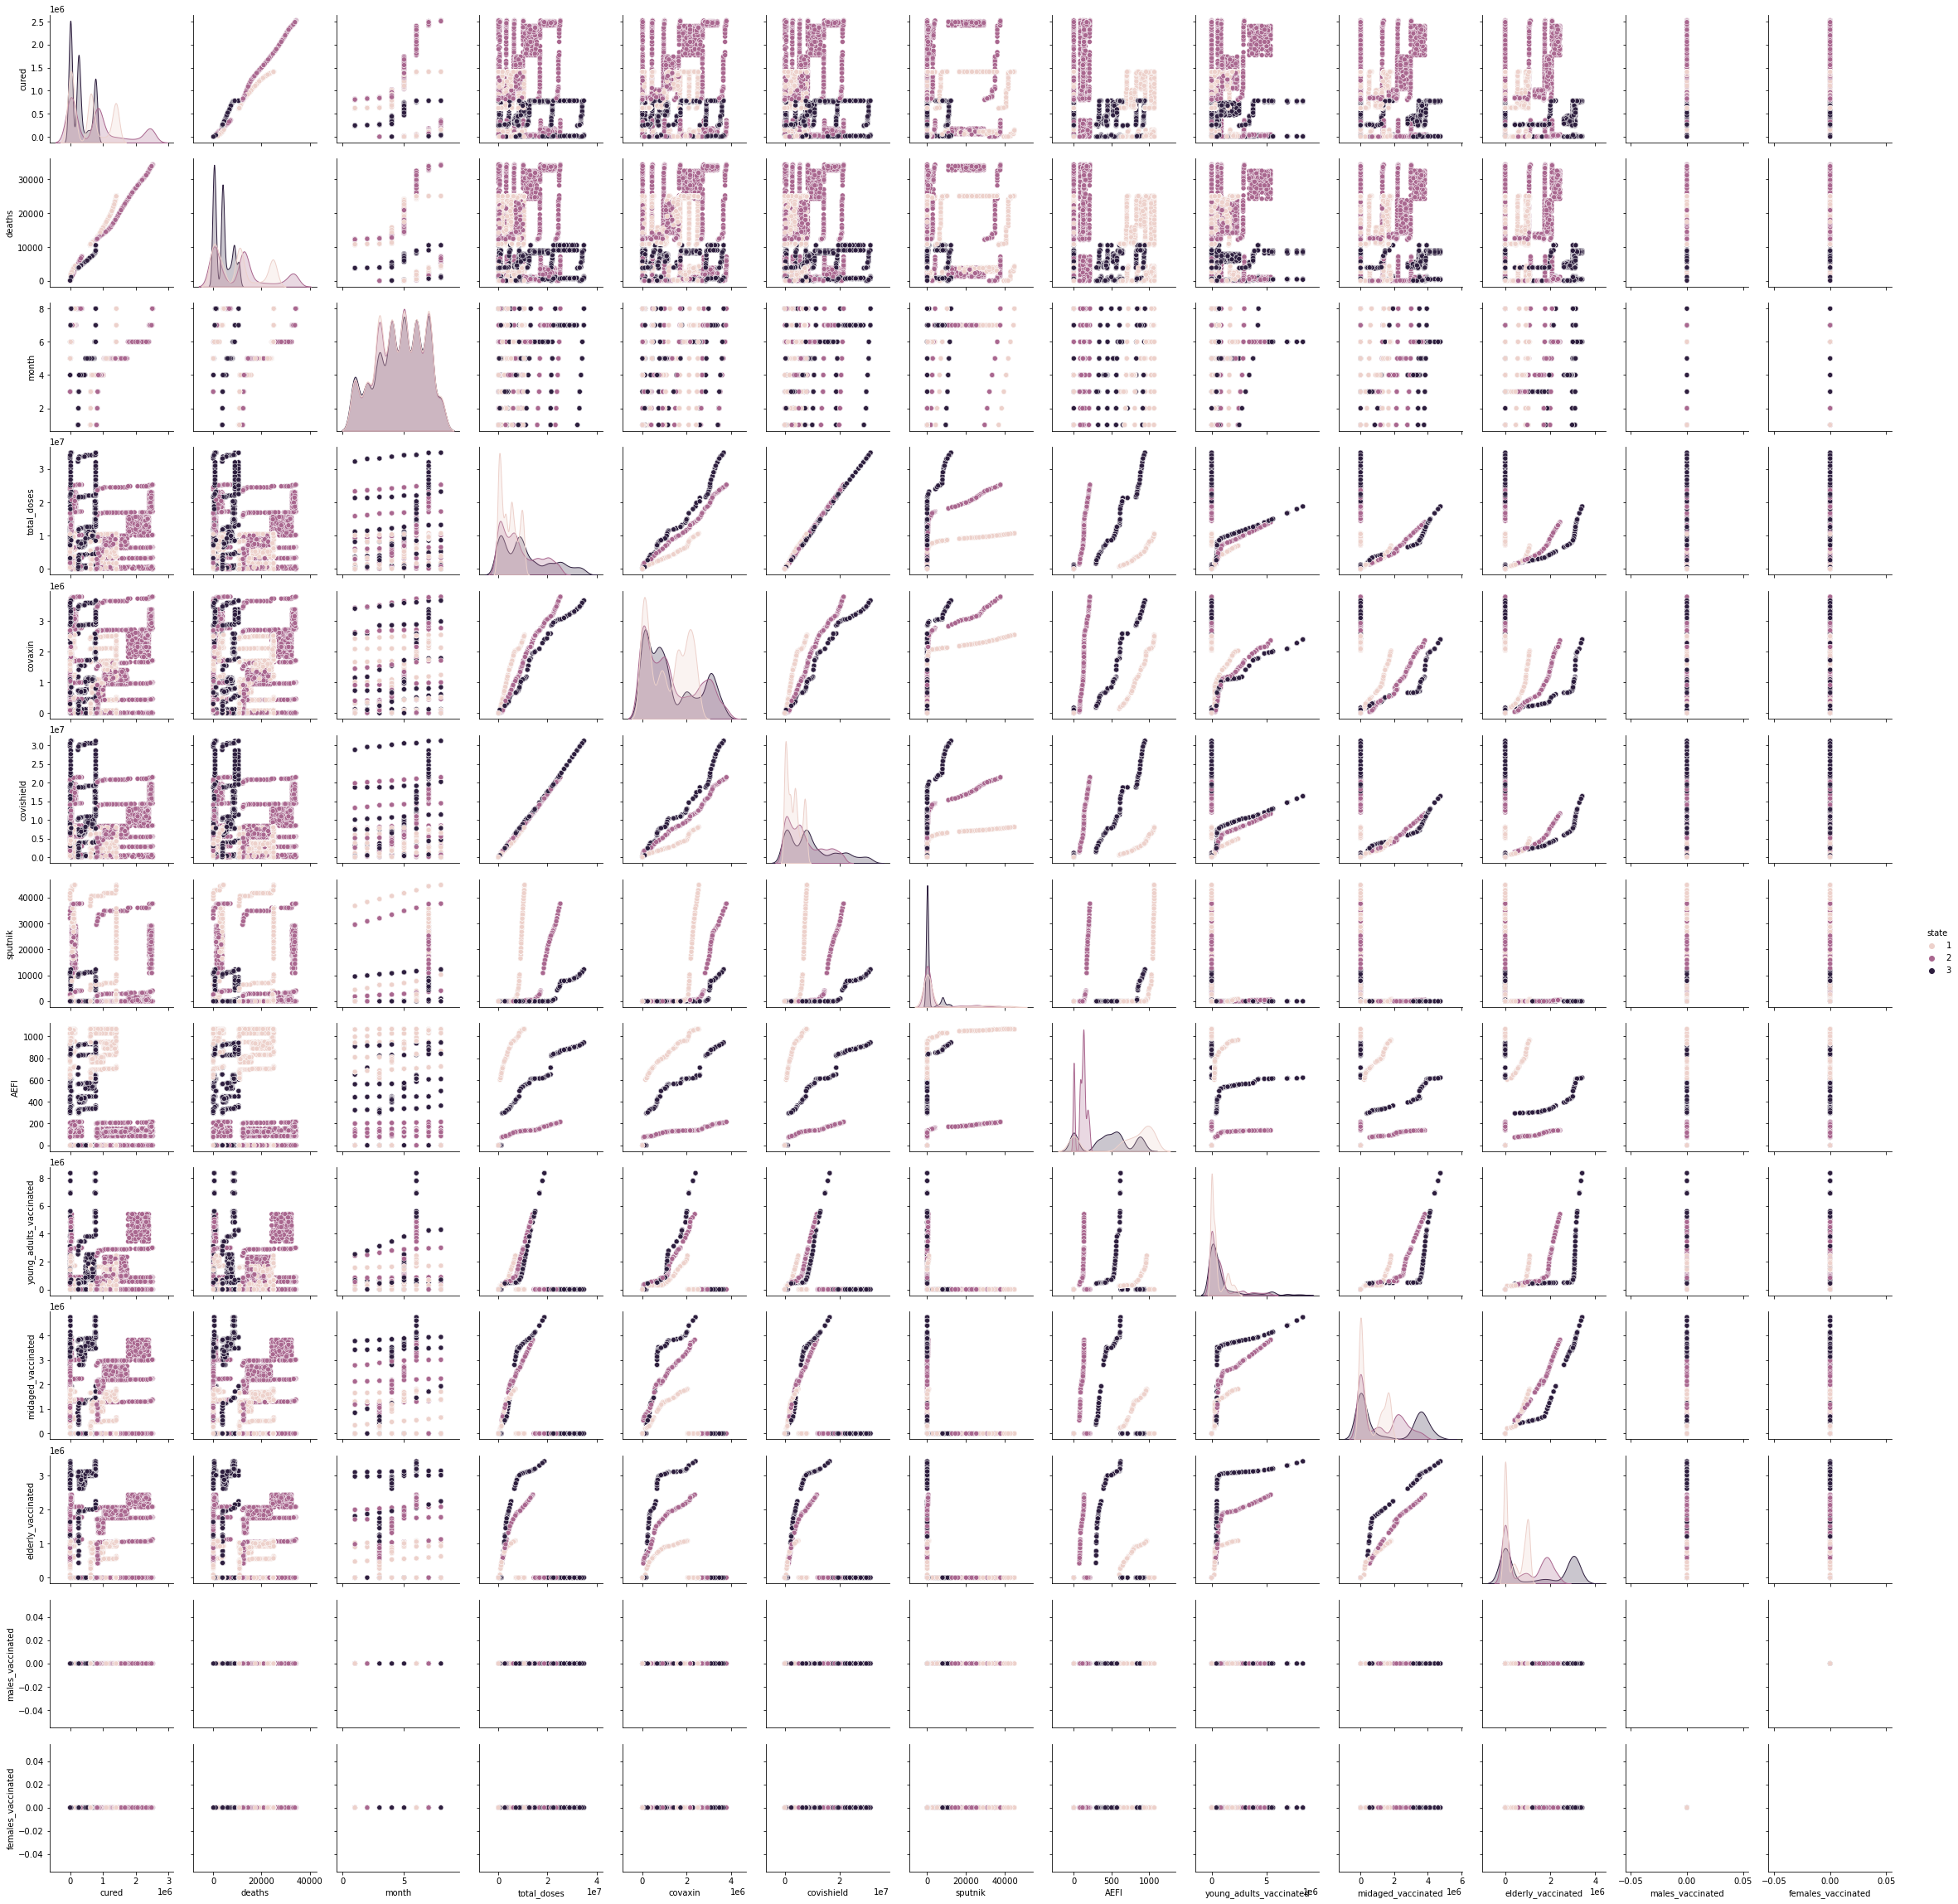

In [35]:
sns.pairplot(train, hue='state')

### Statistical Testing

H0 = state is not correlated to AEFI <br>
Ha = state is correlated to AEFI <br>
We reject H0

In [36]:
r, p = pearsonr(train.state, train.AEFI)
r,p

(-0.26840790748455123, 1.591126762816257e-258)

H0 = state does not influence cured <br>
Ha = state does influence cured <br>
We reject H0

In [37]:
r, p = pearsonr(train.state, train.cured)
r,p

(-0.17136020609193744, 2.85010543838408e-104)

H0 = state does not influence deaths <br>
Ha = state does influence deaths <br>
We reject H0

In [38]:
r, p = pearsonr(train.state, train.deaths)
r,p

(-0.27279951471465813, 2.558814467866469e-267)

H0 = total_doses does not influence deaths <br>
Ha = total_doses does influence deaths <br>
We reject H0

In [39]:
r, p = pearsonr(train.total_doses, train.cured)
r,p

(0.07857073607006694, 4.863102162784955e-23)

State is statistically correlated with cured, deaths, and AEFI. <br>
Total doses is statistically correlated with cured.

### Statistical Testing of Vaccine Type and AEFI
In addition, tests showed that all vaccine types were correlated AEFI, but I believe that this is due more to the limits of this dataset rather than any real effects. <br> <br>
This dataset tracks vaccine information at a state level, and not at a patient level. <br> <br>
The proportion of the vaccine types being used was inter-related, thus the amount of a single vaccine type being administered correlates with the total amount of all vaccine types being administered. <br> <br>
As the total amount of administered vaccines increases, one would also expect the AEFI to increase. <br> <br>
The lack of a unique identifier connecting patient outcome and vaccination type limits what I can test statistically. <br> <br>
Therefore, I am not including the tests for vaccine types on AEFI.

### Takeaways from Explore
- Although data is time-series, a repeating pattern can't be found within this time-frame
- State influences cured, deaths, and AEFI
- cured strongly correlates to deaths, because more infected means both more cured and more deaths
- AEFI may be related to total_doses, this relationship differs greatly by state
- Some daily values have limited use because of different reporting procedures for different clinics (I assume), this may be addressed by resampling by month
#### Best/Worst practices may be learned by examining differences between states

# Model
### The following models are intended to predict AEFI <br>
### Disclaimer:
### This notebook is not intended to be anti-vaccine.
### Rather, predictors of AEFI can be used to optimize clinical protocols to administer vaccines with a lower AEFI rate.
### In addition, this path of inquiry is useful because we can realistically do more to prevent AEFI than we can to prevent the spread of Covid-19.

In [40]:
# Seperating target from predictors in datasets    
X_train, X_validate, X_test, y_train, y_validate, y_test = helper_file.prep_X_y_train(train, validate, test)

In [41]:
# Scale the predictive features, but not the target
X_train, X_validate, X_test = helper_file.scale_data(X_train, X_validate, X_test)

In [42]:
# Convert datasets bach into dataframes
X_train, X_validate, X_test, y_train, y_validate, y_test = helper_file.back_to_df(X_train, X_validate, X_test, y_train, y_validate, y_test)

### Mean Baseline

In [43]:
# Create a mean baseline
X_train, X_validate, X_test, y_train, y_validate, y_test, rmse_train, rmse_validate = helper_file.mean_baseline(X_train, X_validate, X_test, y_train, y_validate, y_test)

RMSE using Mean
Train/In-Sample:  377.94 
Validate/Out-of-Sample:  377.86


In [44]:
# Create the metric_df as a blank dataframe
metric_df = pd.DataFrame()

# Make our first entry into the metric_df with median baseline
metric_df = helper_file.make_metric_df(y_train.AEFI, y_train.AEFI_pred_mean, 'Mean Baseline', metric_df)

### Linear Regression (OLS) Model

In [45]:
# Create and run the linear regression model
X_train, X_validate, X_test, y_train, y_validate, y_test, rmse_train, rmse_validate, metric_df = helper_file.lm_model(X_train, X_validate, X_test, y_train, y_validate, y_test, metric_df)

RMSE for LinearRegression(OLS)
Training/In-Sample:  253.0796858676762 
Validation/Out-of-Sample:  249.7445703463129


### LassLars Model

In [46]:
# Create and run the LassoLars model.
X_train, X_validate, X_test, y_train, y_validate, y_test, rmse_train, rmse_validate, metric_df = helper_file.lasslars_model(X_train, X_validate, X_test, y_train, y_validate, y_test, metric_df)

RMSE for Lasso + Lars
Training/In-Sample:  343.6754044719454 
Validation/Out-of-Sample:  343.2946073711664


### Generalized Linear Model

In [47]:
# Create and run the GLM model.
X_train, X_validate, X_test, y_train, y_validate, y_test, rmse_train, rmse_validate, metric_df = helper_file.glm_model(X_train, X_validate, X_test, y_train, y_validate, y_test, metric_df)

RMSE for GLM using Tweedie
Training/In-Sample:  254.74208139077285 
Validation/Out-of-Sample:  250.87860967267434


In [48]:
metric_df

,model,RMSE_validate,r^2_validate
0,Mean Baseline,377.94035857607815,0.0
1,Linear Regression (OLS),249.7445703463129,0.5631796071188575
2,LassoLars,343.2946073711664,0.17455939672670895
3,Generalized Linear Model,250.87860967267434,0.5592155348785608


### The Linear Model (OLS) is the best performing model according to RMSE and R^2

In [49]:
# Run the best model on test data.
X_train, X_validate, X_test, y_train, y_validate, y_test, rmse_validate, metric_df = helper_file.best_model(X_train, X_validate, X_test, y_train, y_validate, y_test, metric_df)

In [50]:
metric_df

,model,RMSE_validate,r^2_validate
0,Mean Baseline,377.94035857607815,0.0
1,Linear Regression (OLS),249.7445703463129,0.5631796071188575
2,LassoLars,343.2946073711664,0.17455939672670895
3,Generalized Linear Model,250.87860967267434,0.5592155348785608
4,Linear Model (OLS) on Test Data,252.3729457683714,0.5520638067205643


### The Linear Regression (OLS) Model outperforms the mean baseline and the other models

# Conclusion
The different states in India have great influence on:
- the amount of people who survived from Covid.
- the amount of people who died from Covid.
- the amount of adverse reactions from Covid vaccines.
<br> <br>
The plots for cured mirrored the plots for deaths, implying the the number of cured and deaths recorded was mostly dependent on the spread of infection rather than the treatment received. <br> <br>
It could not be determined with this dataset why State had such impact on cured, deaths, and adverse reactions to vaccines. <br>
Drawing such conclusions may require a dataset with a unique identifier tying patient outcome to vaccination status. <br> <br>
### This work is important because it identifies states with best/worst practices, which can be used to improve vaccination, treatment, and prevention protocols.
### The implementation of best practices can enable vaccination with lower AEFI rates.

# Future Work
If I had more time I would like to find a dataset with unique identifiers tying patient outcome to vaccination information. <br>
I would also like to find patient information like insurance status, economic status, health status, etc.